In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scapy.all import sniff, IP, TCP, UDP
import datetime
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import to_categorical


C:\Users\nosib\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\nosib\AppData\Roaming\Python\Python312\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
train_df = pd.read_csv("Train_data.csv")

In [3]:
print("Train columns:", train_df.columns)
train_df.head()

Train columns: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
train_df.dropna(inplace=True)

In [5]:
categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {}

for col in categorical_cols:
    encoders[col] = LabelEncoder()
    train_df[col] = encoders[col].fit_transform(train_df[col])

In [6]:
label_encoder = LabelEncoder()
train_df['class'] = label_encoder.fit_transform(train_df['class'])

X = train_df.drop('class', axis=1)
y = train_df['class']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert labels to one-hot vectors
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [8]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\nosib\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,762 (53.76 KB)

 Trainable params: 13,762 (53.76 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=64, validation_data=(X_val, y_val_cat))

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 35:24 7s/step - accuracy: 0.3594 - loss: 0.80 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.3672 - loss: 0.796 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5312 - loss: 0.7094  ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6643 - loss: 0.599 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7082 - loss: 0.547 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7644 - loss: 0.47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7928 - loss: 0.43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8163 - loss: 0.39 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8317 - loss: 0.37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8425 - loss: 0.35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8530 - loss: 0.33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8603 - loss: 0.32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8654 - loss: 0.31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8713 - loss: 0.30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8768 - loss

In [10]:
y_pred = np.argmax(model.predict(X_val), axis=1)
val_loss, val_accuracy = model.evaluate(X_val, y_val_cat)
print(f"Validation Accuracy: {val_accuracy:.4f}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9688 - loss: 0.026 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9809 - loss: 0.021 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9830 - loss: 0.02 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9856 - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9861 - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9864 - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9865 - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9870 - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9877 - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.98

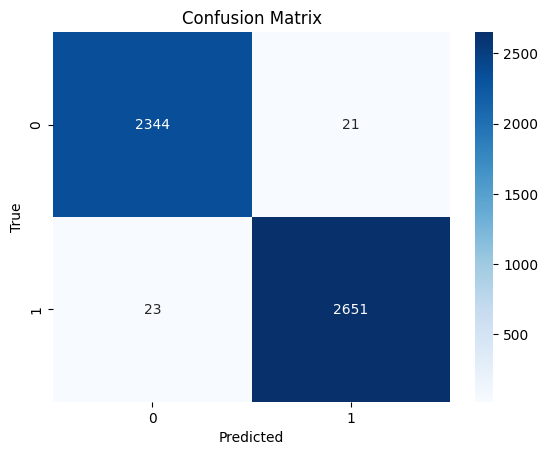

In [11]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      2365
      normal       0.99      0.99      0.99      2674

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



In [ ]:
# Save feature names for use in real-time detection
feature_names = X.columns.tolist()

Live packet sniffing with Scapy + real-time detection and Logging to a text file

In [ ]:
def extract_features(packet):
    data = dict.fromkeys(feature_names, 0)

    if IP in packet:
        proto = 0
        if packet.haslayer(TCP):
            proto = 1
        elif packet.haslayer(UDP):
            proto = 2

        data['protocol_type'] = proto
        data['src_bytes'] = len(packet[IP].payload)
        data['dst_bytes'] = 0  # Set to 0 or estimate if you track both directions

        # Service estimation
        dport = packet.dport if hasattr(packet, 'dport') else None
        if dport:
            if dport in [80, 8080, 443]:
                data['service'] = encoders['service'].transform(['http'])[0]
            elif dport == 53:
                data['service'] = encoders['service'].transform(['domain'])[0]
            else:
                data['service'] = 0

        # Flag mapping
        if packet.haslayer(TCP):
            flags = packet[TCP].flags
            if flags == 'S':
                data['flag'] = encoders['flag'].transform(['S0'])[0]
            elif flags == 'SA':
                data['flag'] = encoders['flag'].transform(['SF'])[0]
            else:
                data['flag'] = 0

    return pd.DataFrame([data])


# Predict and log packet
def classify_packet(packet):
    try:
        features_df = extract_features(packet)

        # Standardize
        features_scaled = scaler.transform(features_df)

        # Predict
        prediction = model.predict(features_scaled)
        label_index = prediction.argmax()
        label = label_encoder.inverse_transform([label_index])[0]

        # Log
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        log = f"{timestamp} | Src: {packet[IP].src} | Dst: {packet[IP].dst} | Label: {label}"
        print(log)

        with open("network_log.txt", "a") as f:
            f.write(log + "\n")

    except Exception as e:
        print("Error:", e)

print("Sniffing live packets")
sniff(filter="ip", prn=classify_packet, store=False, timeout=60)



Sniffing live packets
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2025-05-25 22:22:52 | Src: 192.168.1.220 | Dst: 52.168.112.67 | Label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2025-05-25 22:22:52 | Src: 192.168.1.220 | Dst: 52.168.112.67 | Label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2025-05-25 22:22:52 | Src: 192.168.1.220 | Dst: 52.168.112.67 | Label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2025-05-25 22:22:53 | Src: 192.168.1.220 | Dst: 52.168.112.67 | Label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2025-05-25 22:22:53 | Src: 52.168.112.67 | Dst: 192.168.1.220 | Label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2025-05-25 22:22:53 | Src: 52.168.112.67 | Dst: 192.168.1.220 | Label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2025-05-25 2

<Sniffed: TCP:0 UDP:0 ICMP:0 Other:0>